In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from os import path
sns.set()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import calendar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
import time
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.layers import Conv1D, Flatten,MaxPooling1D
from keras.preprocessing import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import auc

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':'1IFrMKLovSZQ2lzYd_mR7RZm7rsj4N8Hc'})
downloaded.GetContentFile('minisarcasm.csv')
import pandas as pd
xyz = pd.read_csv('minisarcasm.csv')
print(xyz.head(1))

   label     comment     author subreddit  score  ups  downs     date  \
0      0  NC and NH.  Trumpbart  politics      2   -1     -1  2016-10   

           created_utc                                     parent_comment  
0  2016-10-16 23:55:23  Yeah, I get that argument. At this point, I'd ...  


In [ ]:
sarcasm_df = pd.read_csv('minisarcasm.csv')
# Data Pre-Processing
# Removing the null comments
sarcasm_df.dropna(subset=['comment'], inplace=True)
sarcasm_df['comment'] = sarcasm_df['comment'].str.lower()
sarcasm_df['comment'] = sarcasm_df['comment'].str.replace('[^\w\s]','')

In [ ]:
# Converting the timestamp into DateTime object
sarcasm_df.created_utc = pd.to_datetime(sarcasm_df.created_utc)
sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010771 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   label           1010771 non-null  int64         
 1   comment         1010771 non-null  object        
 2   author          1010771 non-null  object        
 3   subreddit       1010771 non-null  object        
 4   score           1010771 non-null  int64         
 5   ups             1010771 non-null  int64         
 6   downs           1010771 non-null  int64         
 7   date            1010771 non-null  object        
 8   created_utc     1010771 non-null  datetime64[ns]
 9   parent_comment  1010771 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 84.8+ MB


In [ ]:
#check whether there are duplicated values

sarcasm_df.duplicated().sum()

28

In [ ]:
#convert uppercase letters to lowercase letters
sarcasm_df = sarcasm_df.apply(lambda x: x.astype(str).str.lower() if x.name == 'comment' else x)


In [ ]:
import string
!pip install nltk
import nltk
from nltk.stem import WordNetLemmatizer
!pip install nltk
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()
lemmatizer = WordNetLemmatizer()
# Remove punctuation
sarcasm_df['comment'] = sarcasm_df['comment'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))

# Remove numbers
sarcasm_df['comment'] = sarcasm_df['comment'].str.replace('\d+', '')

sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010771 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   label           1010771 non-null  int64         
 1   comment         1010771 non-null  object        
 2   author          1010771 non-null  object        
 3   subreddit       1010771 non-null  object        
 4   score           1010771 non-null  int64         
 5   ups             1010771 non-null  int64         
 6   downs           1010771 non-null  int64         
 7   date            1010771 non-null  object        
 8   created_utc     1010771 non-null  datetime64[ns]
 9   parent_comment  1010771 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 84.8+ MB


<ipython-input-8-a0c4490cf354>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label',  data= sarcasm_df, palette=colors)


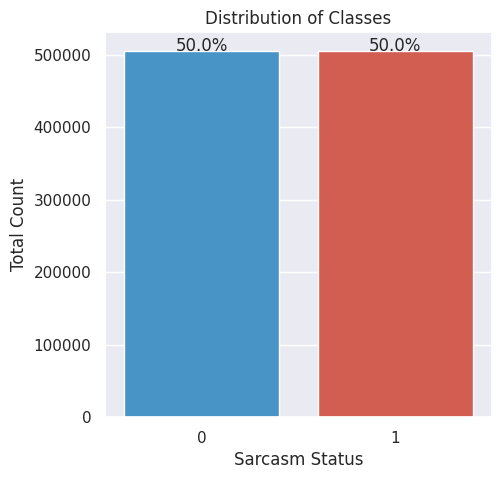

In [ ]:
plt.figure(figsize=(5,5))
colors = ["#3498db", "#e74c3c"]
ax = sns.countplot(x='label',  data= sarcasm_df, palette=colors)
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(sarcasm_df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format((height/total)*100),
            ha="center")
plt.show()

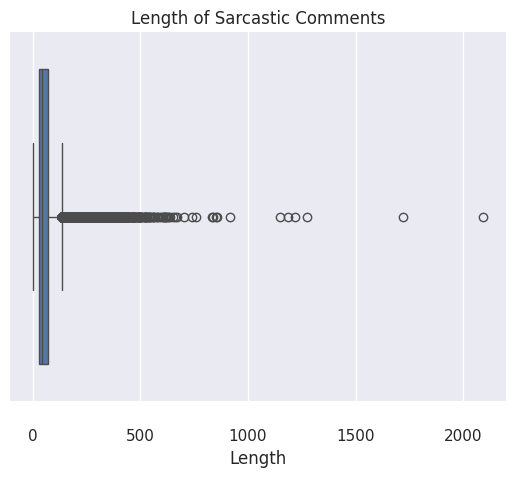

In [ ]:
# Distribution of the lenth of Sarcastic comments
sns.boxplot(x= sarcasm_df.loc[sarcasm_df['label'] == 1, 'comment'].str.len()).set(title = 'Length of Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

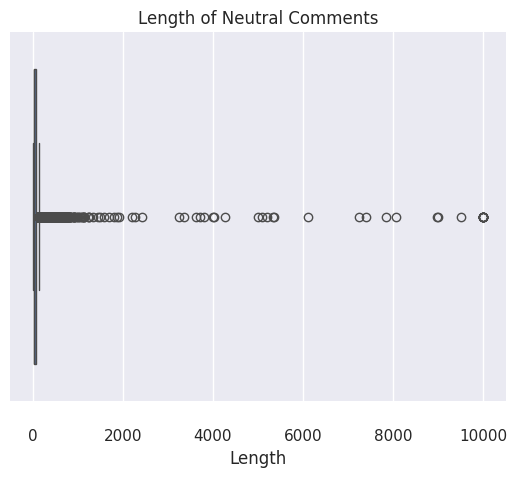

In [ ]:
# Distribution of the length of Neutral comments
sns.boxplot(x= sarcasm_df.loc[sarcasm_df['label'] == 0, 'comment'].str.len()).set(title = 'Length of Neutral Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

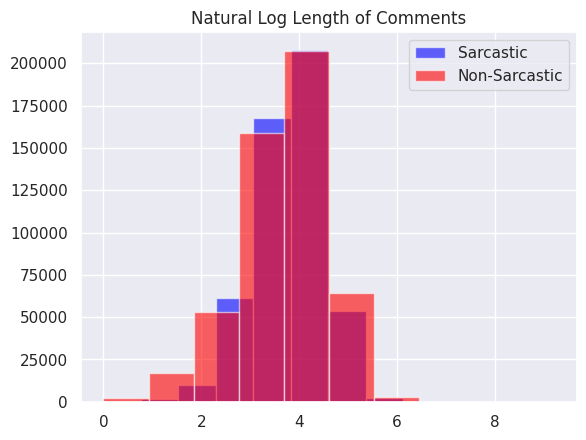

In [ ]:
sarcasm_df['log_comment'] = sarcasm_df['comment'].apply(lambda text: np.log1p(len(text)))
sarcasm_df[sarcasm_df['label']==1]['log_comment'].hist(alpha=0.6,label='Sarcastic', color = 'blue')
sarcasm_df[sarcasm_df['label']==0]['log_comment'].hist(alpha=0.6,label='Non-Sarcastic', color = 'red')
plt.legend()
plt.title('Natural Log Length of Comments')
plt.show()

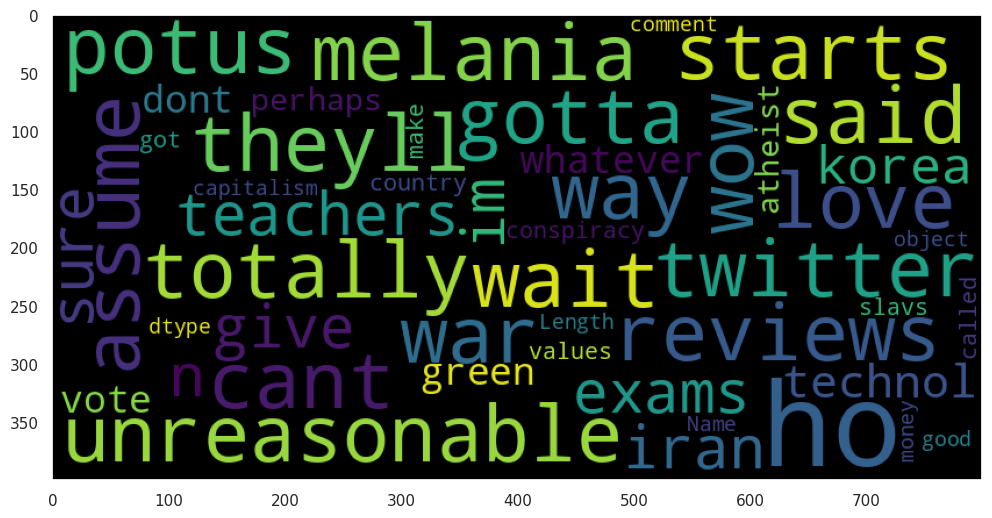

In [ ]:
wordcloud = WordCloud(background_color='black', stopwords=STOPWORDS,
                      max_words=200, max_font_size=100,
                      random_state=17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(sarcasm_df.loc[sarcasm_df['label'] == 1, 'comment']))
plt.grid(False)  # Corrected line
plt.imshow(wordcloud)
plt.show()

In [ ]:
# Converting the scores into numpy array
sarcasm_score = np.array(sarcasm_df.loc[sarcasm_df['label'] == 1]['score'])
neutral_score = np.array(sarcasm_df.loc[sarcasm_df['label'] == 0]['score'])

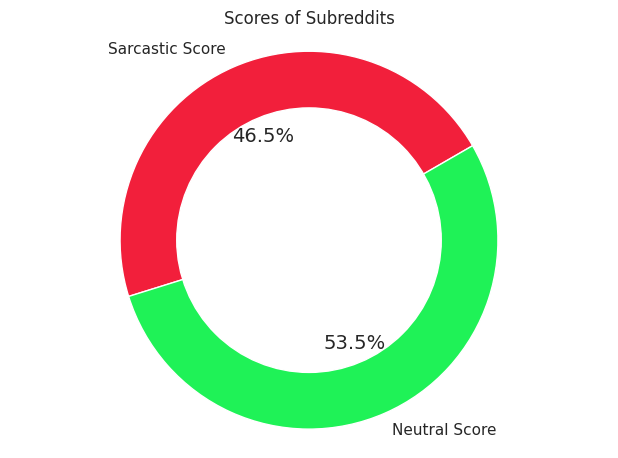

In [ ]:
# Displaying the distribution of Marital Status in a Pie chart
labels = ['Sarcastic Score', 'Neutral Score']
sizes = [3235069, 3725113]
#colors
colors = ['#F21F3B', '#1FF257']

plt.rcParams.update({'font.size': 14})
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=30)
ax1.set_title("Scores of Subreddits")
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
#determine whether the length of the sarcastic comments is more than its parent comment.
sarcasm_comm_len = np.array(sarcasm_df.loc[sarcasm_df['label'] == 1]['comment'].str.len())
parent_comm_len = np.array(sarcasm_df.loc[sarcasm_df['label'] == 1]['parent_comment'].str.len())
ratio_len = np.array((sarcasm_df.loc[sarcasm_df['label'] == 1]['comment'].str.len())/(sarcasm_df.loc[sarcasm_df['label'] == 1]['parent_comment'].str.len()))


In [ ]:
dataset = pd.DataFrame({'Comment Length': sarcasm_comm_len, 'Parent Comment Length': parent_comm_len, 'Ratio Length': ratio_len}, columns=['Comment Length', 'Parent Comment Length', 'Ratio Length'])

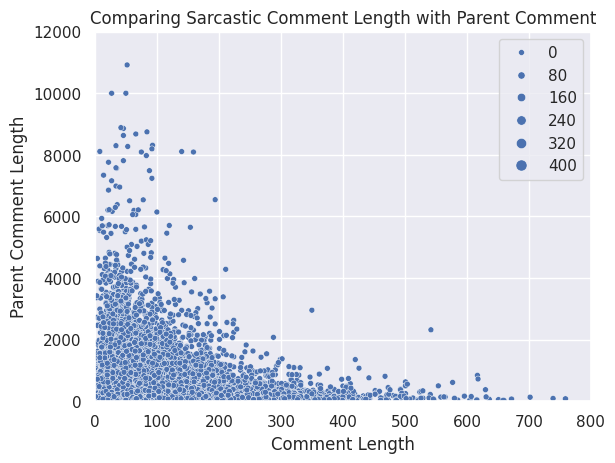

In [ ]:
ax = plt.axes()
sns.scatterplot(data=dataset, x="Comment Length", y="Parent Comment Length",  size=ratio_len)
ax.set_title("Comparing Sarcastic Comment Length with Parent Comment")
# control x and y limits
plt.ylim(0, 12000)
plt.xlim(0, 800)
plt.show()

In [ ]:
# Getting the top 5 popular subreddits
sarcasm_df['subreddit'].value_counts()[:5]

subreddit
AskReddit          65674
politics           39493
worldnews          26375
leagueoflegends    21034
pcmasterrace       18987
Name: count, dtype: int64

In [ ]:
top_reddits =['AskReddit', 'politics', 'worldnews', 'leagueoflegends', 'pcmasterrace']

In [ ]:
subreddit = pd.DataFrame()
subreddit['subreddit'] = top_reddits
subreddit['sarcastic'] = np.nan
subreddit['natural'] = np.nan
subreddit['total'] = np.nan

In [ ]:
# Calculating the count of Sarcastic and Natural comments for the top 5 subreddits
for i in range(len(top_reddits)):
    temp = sarcasm_df.loc[sarcasm_df['subreddit'] == subreddit.subreddit.iloc[i]]
    length = len(temp)
    count_sarcastic = len(temp.loc[temp['label'] == 1])
    subreddit.sarcastic.iloc[i] = count_sarcastic
    subreddit.natural.iloc[i] = length - count_sarcastic
    subreddit.total.iloc[i] = length

<ipython-input-21-d4513a81beb2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit.sarcastic.iloc[i] = count_sarcastic
<ipython-input-21-d4513a81beb2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit.natural.iloc[i] = length - count_sarcastic
<ipython-input-21-d4513a81beb2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit.total.iloc[i] = length
<ipython-input-21-d4513a81beb2>:6: SettingWithCopyWarning: 
A va

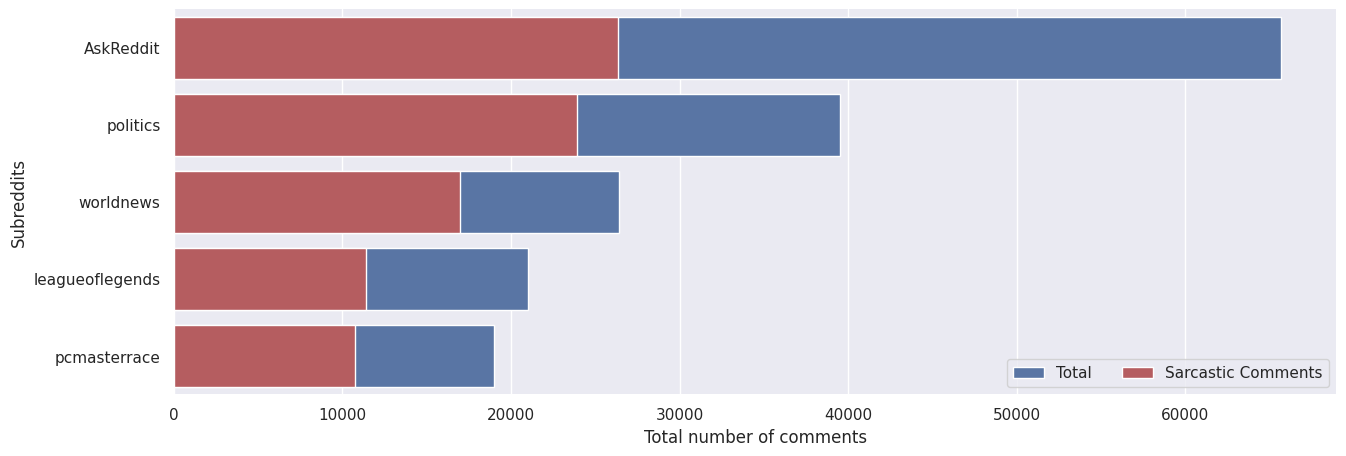

In [ ]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 5))
# Plot the total comments for the subreddits
sns.barplot(x="total", y="subreddit", data=subreddit,
            label="Total", color="b")
# Plot the total sarcastic comments for the subreddits
sns.barplot(x="sarcastic", y="subreddit", data=subreddit,
            label="Sarcastic Comments", color="r")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Subreddits",
       xlabel="Total number of comments")
sns.despine(left=True, bottom=True)

In [ ]:
# Feature Engineering- Extracting the day of a week
sarcasm_df['created_utc'] = pd.to_datetime(sarcasm_df['created_utc'], format = '%d/%m/%Y %H:%M:%S')
sarcasm_df['Day of Week'] = sarcasm_df['created_utc'].dt.day_name()

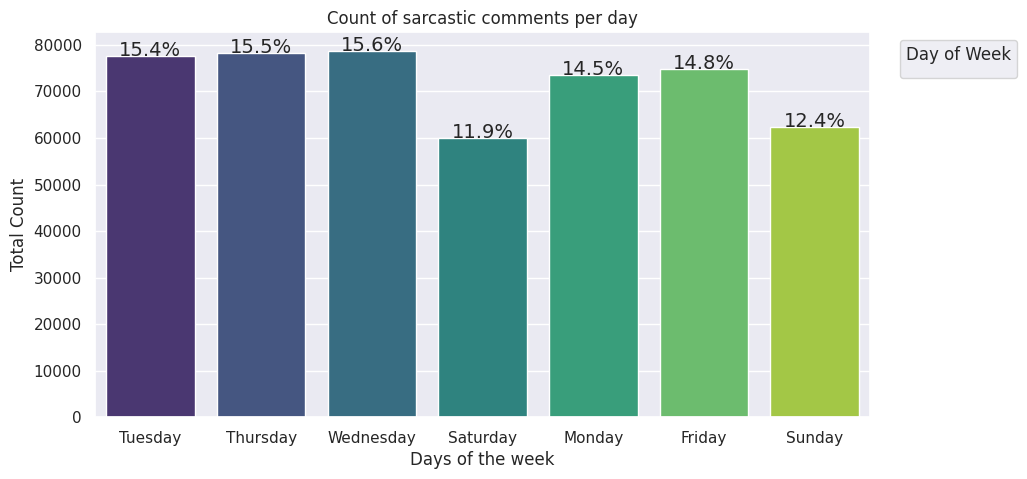

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Day of Week', hue='Day of Week', data=sarcasm_df.loc[sarcasm_df['label'] == 1], palette='viridis')
ax.set(title="Count of sarcastic comments per day", xlabel="Days of the week", ylabel="Total Count")

total = float(len(sarcasm_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 7,
            '{:1.1f}%'.format((height / total) * 100 * 2),
            ha="center")

plt.legend(title="Day of Week", loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


CNN

In [ ]:
vocab_size = 1000
maxlen = 1000
embedding_dims = 50
filters = 32
kernel_size = 3
hidden_dims = 250
epochs = 10

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sarcasm_df['comment'], sarcasm_df['label'], test_size=0.33, random_state=42)

tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [ ]:
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size,embedding_dims,input_length=maxlen))
cnn_model.add(Dropout(.5))
cnn_model.add(Conv1D(filters, kernel_size,padding = 'valid', activation = 'relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters, kernel_size,padding = 'valid', activation = 'relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(hidden_dims, activation ='relu'))
cnn_model.add(Dropout(.5))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

cnn_model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
10582/10582 [==============================] - 2196s 207ms/step - loss: 0.6170 - accuracy: 0.6548 - val_loss: 0.6016 - val_accuracy: 0.6681
Epoch 2/10
10582/10582 [==============================] - 2189s 207ms/step - loss: 0.6057 - accuracy: 0.6663 - val_loss: 0.5991 - val_accuracy: 0.6711
Epoch 3/10
10582/10582 [==============================] - 2176s 206ms/step - loss: 0.6028 - accuracy: 0.6694 - val_loss: 0.6007 - val_accuracy: 0.6722
Epoch 4/10
10582/10582 [==============================] - 2179s 206ms/step - loss: 0.6014 - accuracy: 0.6709 - val_loss: 0.5971 - val_accuracy: 0.6734
Epoch 5/10
10582/10582 [==============================] - 2179s 206ms/step - loss: 0.6001 - accuracy: 0.6723 - val_loss: 0.5980 - val_accuracy: 0.6739
Epoch 6/10
10582/10582 [==============================] - 2203s 208ms/step - loss: 0.5992 - accuracy: 0.6732 - val_loss: 0.5966 - val_accuracy: 0.6749
Epoch 7/10
10582/10582 [==============================] - 2157s 204ms/step - loss: 0.5985 - ac

In [ ]:
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, embedding_dims, input_length=maxlen))
cnn_model.add(Dropout(0.5))
cnn_model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(hidden_dims, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

# Make Predictions
user_input = ["your text input here"]
user_input_sequences = tokenizer.texts_to_sequences(user_input)
user_input_sequences_padded = sequence.pad_sequences(user_input_sequences, maxlen=maxlen)
predictions = cnn_model.predict(user_input_sequences_padded)

# Round predictions to get binary labels (0 or 1)
binary_predictions = [1 if pred >= 0.5 else 0 for pred in predictions]

# Define user labels corresponding to the user input
user_labels = [1]  # Example: Assuming a single label for a single input

# Evaluate Predictions
from sklearn.metrics import accuracy_score

# Check if the number of user labels matches the number of predictions
if len(user_labels) != len(binary_predictions):
    raise ValueError("Number of user labels must match the number of predictions.")

# Calculate accuracy
accuracy = accuracy_score(user_labels, binary_predictions)


1/1 [==============================] - 0s 140ms/step


In [ ]:
# Tokenize and pad the input sentence
input_sentence = "A little self lovin can turn that99 into a 100. Turn that frown upside dwn and beat it like it dos you money!"
input_sequence = tokenizer.texts_to_sequences([input_sentence])
padded_sequence = pad_sequences(input_sequence, maxlen=maxlen)

# Predict using the CNN model
cnn_prediction = cnn_model.predict(padded_sequence)
cnn_prediction_label = "Sarcasm" if cnn_prediction[0][0] > 0.5 else "Not sarcasm"
print("CNN Model Prediction:", cnn_prediction_label)


1/1 [==============================] - 0s 20ms/step
CNN Model Prediction: Not sarcasm


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
cnn_prediction = cnn_model.predict(X_test)
cnn_prediction = np.round(cnn_prediction).astype(int)
# For the CNN model
cnn_accuracy = accuracy_score(y_test, cnn_prediction)
cnn_precision = precision_score(y_test, cnn_prediction)
cnn_recall = recall_score(y_test, cnn_prediction)
cnn_f1 = f1_score(y_test, cnn_prediction)

print("\nCNN Model Metrics:")
print("Accuracy:", cnn_accuracy)
print("Precision:", cnn_precision)
print("Recall:", cnn_recall)
print("F1-score:", cnn_f1)

10424/10424 [==============================] - 146s 14ms/step

CNN Model Metrics:
Accuracy: 0.49985159868687323
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Using a Bidirectional LSTM
sarcasm_df.reset_index(drop = True, inplace = True)
corpus = [sarcasm_df['comment'][i] for i in range( len(sarcasm_df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus]

max_sent_length = 20

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)

embedding_vector_features=40

X_final=np.array(embedded_docs)
y_final=np.array(sarcasm_df['label'])

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [ ]:
lstm_model=Sequential()
lstm_model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent_length))
lstm_model.add(Dropout(0.3))
lstm_model.add(Bidirectional(LSTM(100)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Flatten())
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
lstm_model.fit(X_train_lstm,y_train_lstm,validation_data=(X_test_lstm,y_test_lstm),epochs=10,batch_size=64)

Epoch 1/10
10582/10582 [==============================] - 859s 80ms/step - loss: 0.5920 - accuracy: 0.6791 - val_loss: 0.5732 - val_accuracy: 0.6967
Epoch 2/10
10582/10582 [==============================] - 848s 80ms/step - loss: 0.5678 - accuracy: 0.7013 - val_loss: 0.5679 - val_accuracy: 0.6998
Epoch 3/10
10582/10582 [==============================] - 839s 79ms/step - loss: 0.5579 - accuracy: 0.7084 - val_loss: 0.5645 - val_accuracy: 0.7032
Epoch 4/10
10582/10582 [==============================] - 832s 79ms/step - loss: 0.5508 - accuracy: 0.7140 - val_loss: 0.5651 - val_accuracy: 0.7035
Epoch 5/10
10582/10582 [==============================] - 831s 78ms/step - loss: 0.5444 - accuracy: 0.7184 - val_loss: 0.5643 - val_accuracy: 0.7045
Epoch 6/10
10582/10582 [==============================] - 834s 79ms/step - loss: 0.5389 - accuracy: 0.7230 - val_loss: 0.5628 - val_accuracy: 0.7045
Epoch 7/10
10582/10582 [==============================] - 874s 83ms/step - loss: 0.5335 - accuracy: 0.7267

In [ ]:
y_test_pred_probs = lstm_model.predict(X_test_lstm)
y_train_pred_probs = lstm_model.predict(X_train_lstm)
y_test_pred = np.round(y_test_pred_probs).astype(int)
y_train_pred = np.round(y_train_pred_probs).astype(int)

test_acc_lstm = accuracy_score(y_test_lstm, y_test_pred)
train_acc_lstm = accuracy_score(y_train_lstm, y_train_pred)

print('Train accuracy of lstm: ', train_acc_lstm)
print('Test accuracy of lstm: ', test_acc_lstm)


21163/21163 [==============================] - 235s 11ms/step
Train accuracy of lstm:  0.7591033064136243
Test accuracy of lstm:  0.7058036972411601


In [ ]:
# User-given sentence
input_sentence = "You're adorable"

# Preprocess the input sentence
input_sentence = input_sentence.lower()  # Convert to lowercase

# Tokenize the preprocessed sentence
input_sequence = tokenizer.texts_to_sequences([input_sentence])

# Pad the sequence to match the input size of the model
padded_sequence = pad_sequences(input_sequence, maxlen=max_sent_length)

# Predict using the Bidirectional LSTM model
prediction = lstm_model.predict(padded_sequence)

# Convert prediction probabilities to label
prediction_label = "Sarcasm" if prediction > 0.5 else "Not sarcasm"

print("Bidirectional LSTM Model Prediction:", prediction_label)


1/1 [==============================] - 2s 2s/step
Bidirectional LSTM Model Prediction: Not sarcasm


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the true labels for the test data stored in y_test_lstm

# Predict labels for the test data
y_pred = lstm_model.predict(X_test_lstm)
y_pred_labels = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Compute accuracy
accuracy = accuracy_score(y_test_lstm, y_pred_labels)

# Compute precision
precision = precision_score(y_test_lstm, y_pred_labels)

# Compute recall
recall = recall_score(y_test_lstm, y_pred_labels)

# Compute F1-score
f1 = f1_score(y_test_lstm, y_pred_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

10424/10424 [==============================] - 138s 13ms/step
Accuracy: 0.5371078232975072
Precision: 0.5238510170317796
Recall: 0.81803305220378
F1-score: 0.6386951841624936


In [ ]:
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences


In [ ]:
sarcasm_df = pd.read_csv('minisarcasm.csv')
corpus_lstm = [str(sarcasm_df['comment'][i]) for i in range(len(sarcasm_df))]
voc_size_lstm = 5000
onehot_lstm = [one_hot(str(words), voc_size_lstm) for words in corpus_lstm]

max_sent_length_lstm = 20
embedded_docs_lstm = pad_sequences(onehot_lstm, padding='pre', maxlen=max_sent_length_lstm)

embedding_vector_features_lstm = 40


In [ ]:
X_final_lstm = np.array(embedded_docs_lstm)
y_final_lstm = np.array(xyz['label'])

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_final_lstm, y_final_lstm, test_size=0.33, random_state=42)


In [ ]:
# Vanilla LSTM Model
lstm_model = Sequential()
lstm_model.add(Embedding(voc_size_lstm, embedding_vector_features_lstm, input_length=max_sent_length_lstm))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(100))
lstm_model.add(Dropout(0.3))
lstm_model.add(Flatten())
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_lstm, validation_data=(X_test_lstm, y_test_lstm), epochs=10, batch_size=64)


Epoch 1/10
10583/10583 [==============================] - 440s 41ms/step - loss: 0.5924 - accuracy: 0.6795 - val_loss: 0.5741 - val_accuracy: 0.6946
Epoch 2/10
10583/10583 [==============================] - 458s 43ms/step - loss: 0.5685 - accuracy: 0.7009 - val_loss: 0.5675 - val_accuracy: 0.6999
Epoch 3/10
10583/10583 [==============================] - 462s 44ms/step - loss: 0.5586 - accuracy: 0.7078 - val_loss: 0.5646 - val_accuracy: 0.7019
Epoch 4/10
10583/10583 [==============================] - 464s 44ms/step - loss: 0.5515 - accuracy: 0.7134 - val_loss: 0.5630 - val_accuracy: 0.7042
Epoch 5/10
10583/10583 [==============================] - 460s 43ms/step - loss: 0.5454 - accuracy: 0.7183 - val_loss: 0.5622 - val_accuracy: 0.7057
Epoch 6/10
10583/10583 [==============================] - 443s 42ms/step - loss: 0.5398 - accuracy: 0.7226 - val_loss: 0.5625 - val_accuracy: 0.7061
Epoch 7/10
10583/10583 [==============================] - 459s 43ms/step - loss: 0.5347 - accuracy: 0.7258

In [ ]:
# Evaluation
y_test_pred_probs_lstm = lstm_model.predict(X_test_lstm)
y_train_pred_probs_lstm = lstm_model.predict(X_train_lstm)
y_test_pred_lstm = np.round(y_test_pred_probs_lstm).astype(int)
y_train_pred_lstm = np.round(y_train_pred_probs_lstm).astype(int)

test_acc_lstm = accuracy_score(y_test_lstm, y_test_pred_lstm)
train_acc_lstm = accuracy_score(y_train_lstm, y_train_pred_lstm)

print('Train accuracy of LSTM: ', train_acc_lstm)
print('Test accuracy of LSTM: ', test_acc_lstm)

21165/21165 [==============================] - 160s 8ms/step
Train accuracy of LSTM:  0.755646708098746
Test accuracy of LSTM:  0.7064660509093962


In [ ]:
# Vanilla LSTM Model
lstm_model = Sequential()
lstm_model.add(Embedding(voc_size_lstm, embedding_vector_features_lstm, input_length=max_sent_length_lstm))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(100))
lstm_model.add(Dropout(0.3))
lstm_model.add(Flatten())
lstm_model.add(Dense(1, activation='sigmoid'))


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

training_data = ["1 Key Alpha Boost"]

# Create a Tokenizer object
tokenizer = Tokenizer()

# Fit the tokenizer on your training data
tokenizer.fit_on_texts(training_data)
# Tokenize and pad the input sentence

input_sentence = "You're adorable"
input_sequence = tokenizer.texts_to_sequences([input_sentence])
padded_sequence = pad_sequences(input_sequence, maxlen=max_sent_length_lstm)

# Predict using the LSTM model
lstm_prediction = lstm_model.predict(padded_sequence)
lstm_prediction_label = "Sarcasm" if lstm_prediction[0][0] > 0.5 else "Not sarcasm"
print("LSTM Model Prediction:", lstm_prediction_label)


1/1 [==============================] - 0s 73ms/step
LSTM Model Prediction: Sarcasm


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Check the shape and type of embedded_docs_lstm
print("Shape of embedded_docs_lstm:", embedded_docs_lstm.shape)
print("Type of embedded_docs_lstm:", type(embedded_docs_lstm))

# Check the shape and type of xyz['label']
print("Shape of xyz['label']:", xyz['label'].shape)
print("Type of xyz['label']:", type(xyz['label']))

# Ensure that the shapes are compatible for train_test_split
print("Expected shape for X_final_lstm:", embedded_docs_lstm.shape)
print("Expected shape for y_final_lstm:", xyz['label'].shape)

# Split the data into training and testing sets
try:
    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(embedded_docs_lstm, xyz['label'], test_size=0.33, random_state=42)
    print("Data split successfully.")
except Exception as e:
    print("Error occurred during data split:", e)


Shape of embedded_docs_lstm: (1010826, 20)
Type of embedded_docs_lstm: <class 'numpy.ndarray'>
Shape of xyz['label']: (1010826,)
Type of xyz['label']: <class 'pandas.core.series.Series'>
Expected shape for X_final_lstm: (1010826, 20)
Expected shape for y_final_lstm: (1010826,)
Data split successfully.


In [ ]:
# Check model compilation
print("Model Summary:")
print(lstm_model.summary())

# Check input shape
print("Shape of X_test_lstm:", X_test_lstm.shape)

# Predict probabilities for the test data
y_test_prob_lstm = lstm_model.predict(X_test_lstm)

# Debugging: Print first few values of y_test_prob_lstm
print("First few predictions:")
print(y_test_prob_lstm[:5])

Model Summary:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 40)            200000    
                                                                 
 dropout_6 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 flatten_3 (Flatten)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256501 (1001.96 KB)
Train

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predict probabilities for the test data
y_test_prob_lstm = lstm_model.predict(X_test_lstm)

# Convert probabilities to class labels based on a threshold
threshold = 0.5
y_test_pred_lstm = (y_test_prob_lstm > threshold).astype(int)


# For the LSTM model
lstm_accuracy = accuracy_score(y_test_lstm, y_test_pred_lstm)
lstm_precision = precision_score(y_test_lstm, y_test_pred_lstm)
lstm_recall = recall_score(y_test_lstm, y_test_pred_lstm)
lstm_f1 = f1_score(y_test_lstm, y_test_pred_lstm)

print("LSTM Model Metrics:")
print("Accuracy:", lstm_accuracy)
print("Precision:", lstm_precision)
print("Recall:", lstm_recall)
print("F1-score:", lstm_f1)

10425/10425 [==============================] - 95s 9ms/step
LSTM Model Metrics:
Accuracy: 0.4915205966909792
Precision: 0.4927266819714394
Recall: 0.5543071834328036
F1-score: 0.5217060274938314
